In [50]:
# import pyade.lshade
%matplotlib widget
import numpy as np
from numba import jit
import time

from mealpy.bio_based import BBO
from mealpy.evolutionary_based.DE import L_SHADE
from mealpy.evolutionary_based.MA import OriginalMA
from mealpy.swarm_based.MSA import OriginalMSA

from mealpy.utils.problem import Problem
# from geomdl import NURBS
# from geomdl import knotvector

#import inspect
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18
# %matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
plt.rcParams.update({'figure.max_open_warning': 1})

from robots_models import *



In [51]:
def compute_field(C, p=np.array([0., 0., 0.]).T, T_total=2,Kf=10, eta=1, P=1,dt=0.01):
    # t=np.linspace(-1,1,5)
    # Compute minimum distance
    # print(C.shape)
    m = np.sqrt(np.sum(((p.reshape((3,1))*(np.ones((1,len(C))))).T -C)**2, axis=1))
    # print(m.shape)
    D = np.min(m)
    k_min = np.argmin(m)
    # print(k_min)
    # Compute parameter of the closest point
    # s_star = C.T[k_min]
    # s_star = t[k_min]
    # print(s_star)
    # Compute closest point
    p_star = C.T[:,k_min]
    # print(p_star)

    # Compute distance vector
    D_vec = p-p_star

    # %Compute gradient of the distance function
    grad_D = D_vec/(D+1e-18)

    # %Compute tangent vector
    
    T = (-C.T[:,k_min-1] + C.T[:,k_min])/dt
    # T = (fn_trajectory(s_star+1e-3)-fn_trajectory(s_star-1e-3))/(2e-3)
    
    T = T/np.linalg.norm(T)
    # print(T)

    # %Compute "modulation" functions
    G = -(2/np.pi)*np.arctan(Kf*D)
    H = np.sqrt(1-G*G)

    # Compute field
    F = eta*(G*grad_D + H*T)

    return F

In [52]:
# # def compute_field2(fn_trajectory, p=np.array([0., 0., 0.]).T, t=np.linspace(-1,1,5),Kf=10, eta=1):
    
#     C = fn_trajectory(t)
#     print(C.shape)
#     C = C.T
#     # Compute minimum distance
#     m = np.sqrt(np.sum((p.reshape((3,1))*(np.ones((1,len(t)))) -C)**2, axis=0))
#     print(m.shape)
#     D = np.min(m)
#     k_min = np.argmin(m)
#     print(k_min)
#     # Compute parameter of the closest point
#     s_star = t[k_min]
#     print(s_star)
#     # Compute closest point
#     p_star = C[:,k_min]
#     print(p_star)

#     # Compute distance vector
#     D_vec = p-p_star

#     # %Compute gradient of the distance function
#     grad_D = D_vec/(D+1e-6)

#     # %Compute tangent vector
#     T = (fn_trajectory(s_star+1e-3)-fn_trajectory(s_star-1e-3))/(2e-3)
#     T = T/np.linalg.norm(T)
#     print(T)

#     # %Compute "modulation" functions
#     G = -(2/np.pi)*np.arctan(Kf*D)
#     H = np.sqrt(1-G*G)

#     # Compute field
#     F = eta*(G*grad_D + H*T)

#     return F

In [53]:
# fn1 = lambda t: np.array([np.sin(2*t),  np.sin(t + np.pi/2), t]).T
# compute_field2(fn_trajectory=fn1, p=np.array([1., -1., 0.]).T)

In [54]:
# t=np.linspace(-1,1,5000)
# curve = fn1(t)
# compute_field(C=curve, p=np.array([1., -1., 0.]).T)

In [55]:
class despline3d:

    def __init__(self, type = "DE-SPLINE", debug=0 ):
        '''
        type = DE-NURBS or DE-SPLINE        
        use set_problem and set_algorithm to customize
        '''   
        self.type = type        

        self.problem_defined = False
        self.algorithm_defined = False
        

        # log variables
        self.log_fit = []
        self.log_time = []
        self.log_path = [] 
        self.debug = debug
        
        # log variables
        self.log_fit = []
        self.log_time = []
        self.log_path = [] 
        
        

    def set_problem(self, problem_params = None):
        ''' Set problem params 
        
        
        
        '''

        if problem_params is None:            
            problem_params = {
            "r": 0.075/2*np.sqrt(2),            
            "pinit":[0.0, 0.0,0.],
            "pgoal":[1., 1.,0.], 
            "vinit":[1., .0,0.], 
            "vgoal":[1., 0.0,0.],
            "obs" : [],             
            "dt" : 0.01, 
            "npoints": 20,             
            "nsplines": 2,
            "lb": [-2, -2, -2, -2, -2, -2],
            "ub": [2, 2, 2, 2, 2, 2],
            "alpha_costfunction" : 0.00125,
            "external_costfunction": None,
            }
        else:
            self.problem_params = problem_params        

        self.r = self.problem_params["r"]
        self.obs = self.problem_params["obs"]
        self.pinit = self.problem_params["pinit"]
        self.pgoal = self.problem_params["pgoal"]
        self.vinit = self.problem_params["vinit"]
        self.vgoal = self.problem_params["vgoal"]
        self.npoints = self.problem_params["npoints"]
        
        self.dt = self.problem_params["dt"]
        self.nsplines = self.problem_params["nsplines"]
        self.alpha = self.problem_params["alpha_costfunction"]

        if problem_params["external_costfunction"] is not None: 
            self.costfunction = problem_params["external_costfunction"]
        elif self.type in "DE-SPLINE":
            self.costfunction = self.costfunction_spline

        self.problem_defined = True
        # self.dt = np.linalg.norm(np.array(self.pinit)-np.array(self.pgoal))/self.npoints
        self.problem_dict = {
            "fit_func": self.costfunction,
            "lb": self.problem_params["lb"],
            "ub": self.problem_params["ub"],
            "minmax": "min",
            "log_to": None,
        }
        
        

    def get_problem_params(self):
        return self.problem_params
    
    def get_algorithm_params(self):
        return self.algorithm_params
    
    def set_algorithm(self,algorithm_params=None):
        '''
        Set algorithm params:
        
        '''     
        if not self.problem_defined:
            print("Problem is not defined.")
            return None
        if algorithm_params is None:            
            algorithm_params = {
                "algorithm": "OriginalMSA",                
                "population_size" : 50,
                "nbest": 5,
                "partition":0.5,
                "max_step_size":1.0,
                # "memory_size" : 3, 
                "max_iterations" : 1000,
                "boundaries" : [],           
            }
        else:
            self.algorithm_params = algorithm_params

        if self.type in "DE-SPLINE":
            self.dim = 3*self.nsplines

        self.algorithm = algorithm_params["algorithm"]

        if self.algorithm in "OriginalMSA":
            self.model = OriginalMSA(epoch=algorithm_params["max_iterations"], pop_size=algorithm_params["population_size"], \
                n_best=algorithm_params["nbest"], partition=algorithm_params["partition"], max_step_size=algorithm_params["max_step_size"])
        elif self.algorithm in "LSHADE":
            self.model = L_SHADE(epoch=algorithm_params["max_iterations"], pop_size=algorithm_params["population_size"], \
                miu_f=algorithm_params["miu_f"], miu_cr=algorithm_params["miu_cr"])
        self.algorithm_defined = True

    def print_params(self) :
        # signature = inspect.signature(self.__init__)
        # for name, parameter in signature.parameters.items():
        #     print(name, parameter.default, parameter.annotation, parameter.kind)
        print(self.type)
        print(self.algorithm_params)
        print(self.problem_params)
    
    @jit(forceobj=True)
    def run(self, repeat_test=1):

        if not self.problem_defined:
            print("Problem is not defined.")
            return None
        if not self.algorithm_defined:
            print("Algorithm is not defined.")
            return None

        self.log_fit  = []
        self.log_time = []
        self.log_path = []
        
        for i in range(repeat_test):
            
            

            start = time.time()
            # We run the algorithm and obtain the results
            # solution, fitness = algorithm.apply(timeT=2,**params)
            solution, fit_value = self.model.solve(self.problem_dict)
            now = time.time()
            time_elapse = now - start 

            best_solution = solution             
            #self.printlog(str(i)  + " - Solution = " + str(best_solution) + str(fit_value))    
            
            self.log_path.append(best_solution)
            self.log_fit.append(fit_value)
            self.log_time.append(time_elapse)
         
            
    def printlog(self, msg):
        if self.debug:
            print(msg)    

        

    def set_obstacles(self, obs):
        self.obs = obs    

    def spline(self, p0, p1, p0l, p1l, dt=None):
        """ retorna um conjunto de pontos que compõem um spline, componente x: fx e componente y: fy
        """  
        # t = np.linspace(0,1,int(self.npoints/2))#
        if dt is None:
            t = np.arange(0,1,self.dt)  
        else:
            t = np.arange(0,1,dt)  
        f1 = 2*t**3 -3*t**2 + 1
        f2 = -2*t**3 + 3*t**2
        f3 = t**3 -2*t**2 + t
        f4 = t**3 - t**2    

        fx = p0[0]*f1 + p1[0]*f2 + p0l[0]*f3 + p1l[0]*f4
        fy = p0[1]*f1 + p1[1]*f2 + p0l[1]*f3 + p1l[1]*f4
        fz = p0[2]*f1 + p1[2]*f2 + p0l[2]*f3 + p1l[2]*f4

        return fx, fy, fz

    
    
    @jit(forceobj=True)
    def costfunction_spline(self, parameters):
        """ retorna a função de custo, combinação entre suavidade e comprimento
        parameters deve conter uma lista com 4 elementos"""        

        # define os pontos
        p0 = np.array([self.pinit[0], self.pinit[1], self.pinit[2]])
        p0l = np.array([self.vinit[0], self.vinit[1], self.vinit[2]])
        
        
        

        if np.round(parameters[5]*10,0) >= 2:
            p1 = p2 = np.array([parameters[0], parameters[1], parameters[2]])
            x = np.cos(parameters[3]) * np.cos(parameters[4])
            z = np.sin(parameters[3]) * np.cos(parameters[4])
            y = np.sin(parameters[4])
            p1l = np.array([x,y,z])
            # p1l = np.array([parameters[3], parameters[4], parameters[5]])
            # p1l = p1l/(np.linalg.norm(p1l)+1e-18)
            

            #a = time.time()
            # obtem dois splines
            fx1, fy1, fz1 = self.spline(p0, p1, p0l, p1l)
            p2l = p1l
            p3 = np.array([self.pgoal[0], self.pgoal[1], self.pgoal[2]])
            p3l = np.array([self.vgoal[0], self.vgoal[1], self.vgoal[2]])                
            p3l = p3l/(np.linalg.norm(p3l)+1e-18)
            fx2, fy2, fz2 = self.spline(p2, p3, p2l, p3l)
            #print("curve = ", time.time() - a) 

            # une os splines
            fcx = np.append(fx1,fx2[1:])
            fcy = np.append(fy1,fy2[1:])
            fcz = np.append(fz1,fz2[1:])

            fx = fcx
            fy = fcy
            fz = fcz
        else:
            p1 = np.array([self.pgoal[0], self.pgoal[1], self.pgoal[2]])
            p1l = np.array([self.vgoal[0], self.vgoal[1], self.vgoal[2]])          
            p1l = p1l/(np.linalg.norm(p1l)+1e-18)

            # p1l = np.array([path_params[3], path_params[4], path_params[5]])
            # p1l = p1l/(np.linalg.norm(p1l)+1e-18)
            fx1, fy1, fz1 = self.spline(p0, p1, p0l, p1l)
            fx = fx1
            fy = fy1
            fz = fz1
        # verifica se o caminho está livre de obstáculos
        #a = time.time()
        #penalidade = self.isfree(fcx, fcy)
        penalidade  = 0
        # if max(fx) > 1.5 -self.r  or min(fx) < 0.0 + self.r  or max(fy) > 1.3 -self.r  or min(fy) < 0.0 +self.r :
        #     penalidade += 10e6

        # test = [(1/(o[3]+self.r)**2)*(np.array(fx)-o[0])**2 + \
        #         (1/(o[4]+self.r)**2)*(np.array(fy)-o[1])**2 + \
        #         (1/(o[5]+self.r)**2)*(np.array(fz)-o[2])**2 for o in self.obs] 
        test = [(1/(o[3]+self.r)**2)*(np.array(fx)-o[0])**2 + \
                (1/(o[4]+self.r)**2)*(np.array(fy)-o[1])**2 for o in self.obs] 
        test = np.array(test)
        penalidade += len(test[test < 1 ])*10e6

        # obtém a suavidade s do caminho e o comprimento total l do caminho
        # s, l = self.smoothness(fcx, fcy)
        #a = time.time()
        
        smoothness = 0
        
        # ai = np.linalg.norm(np.diff(np.array([fx[:-1],fy[:-1]])).T, axis=1)
        # bi = np.linalg.norm(np.diff(np.array([fx[1:],fy[1:]])).T, axis=1) #np.diff(np.array([fx,fy])).T #np.linalg.norm(pt1-pt)
        # pt = np.array([fx[2:],fy[2:]])
        # pt2 = np.array([fx[:-2],fy[:-2]])  
        # ci = np.linalg.norm((pt2-pt).T, axis=1)

        # th = (ai**2 + bi**2 - ci**2)/(2*ai*bi)
        # th = np.clip(th, a_min=-1.0, a_max=1.0)
        # v = np.diff(np.array([fx,fy]))      
        # #print(v.shape, np.linalg.norm(v, axis=0).shape, len((2*(np.pi - np.arccos(th))/(ai + bi))**2))
        # smoothness = np.sum(np.linalg.norm(v[:,1:], axis=0)*(2*(np.pi - np.arccos(th))/(ai + bi))**2)         
        # #smoothness = self.dt*np.sum((2*(np.pi - np.arccos(th))/(ai + bi))**2) 

        # if np.isnan(smoothness):
        #     smoothness = 10e6
        length =  np.sum(np.linalg.norm(np.diff(np.array([fx,fy, fz])).T, axis=1))
        # length =  np.sum(np.linalg.norm(np.diff(np.array([fx1,fy1])).T, axis=1)) + np.sum(np.linalg.norm(np.diff(np.array([fx2,fy2])).T, axis=1))

        f2 = smoothness
        f1 = length        

        return self.alpha*f2 + f1 + penalidade



    def get_curve_points(self, path_params, problem_params, dt=None):
        """
        input: path_params, problem_params
        return: fx, fy (curve points x, y)
        """
        
        pinit = problem_params["pinit"]
        pgoal = problem_params["pgoal"]
        vinit = problem_params["vinit"]
        vgoal = problem_params["vgoal"]
        npoints = problem_params["npoints"]
        if dt is None:
            dt = self.dt
        # dt = np.linalg.norm(np.array(pinit)-np.array(pgoal))/npoints
        
        
        # problem_params["dt"] =  dt
        if self.type in "DE-SPLINE":            
            # Define the points of the curve  
            #  
            p0 = np.array([self.pinit[0], self.pinit[1], self.pinit[2]])
            p0l = np.array([self.vinit[0], self.vinit[1], self.vinit[2]])
            

            

            if np.round(path_params[5]*10,0) >= 2:
                p1 = p2 = np.array([path_params[0], path_params[1], path_params[2]])
                x = np.cos(path_params[3]) * np.cos(path_params[4])
                z = np.sin(path_params[3]) * np.cos(path_params[4])
                y = np.sin(path_params[4])
                p1l = np.array([x,y,z])

                # p1l = np.array([path_params[3], path_params[4], path_params[5]])
                # p1l = p1l/(np.linalg.norm(p1l)+1e-18)
                fx1, fy1, fz1 = self.spline(p0, p1, p0l, p1l,dt=dt)
                print("2 x spline")
                p2l = p1l
                p3 = np.array([self.pgoal[0], self.pgoal[1], self.pgoal[2]])
                p3l = np.array([self.vgoal[0], self.vgoal[1], self.vgoal[2]])          
                p3l = p3l/(np.linalg.norm(p3l)+1e-18)
                
                fx2, fy2, fz2 = self.spline(p2, p3, p2l, p3l,dt=dt)
                #print("curve = ", time.time() - a) 

                # une os splines
                fcx = np.append(fx1,fx2[1:])
                fcy = np.append(fy1,fy2[1:])
                fcz = np.append(fz1,fz2[1:])

                fx = fcx
                fy = fcy
                fz = fcz
            else:
                
                print("1 x spline")
                p1 = np.array([self.pgoal[0], self.pgoal[1], self.pgoal[2]])
                p1l = np.array([self.vgoal[0], self.vgoal[1], self.vgoal[2]])          
                p1l = p1l/(np.linalg.norm(p1l)+1e-18)

                # p1l = np.array([path_params[3], path_params[4], path_params[5]])
                # p1l = p1l/(np.linalg.norm(p1l)+1e-18)
                fx1, fy1, fz1 = self.spline(p0, p1, p0l, p1l,dt=dt)
                fx = fx1
                fy = fy1
                fz = fz1

            
        return fx, fy, fz

     

In [56]:
def plot_ellipsoid(center=(0,0,0), dimensions=(0.1,0.1,0.1), ax=None, Npoints=100, color='red', alpha=0.2):

        u = np.linspace(0.0, 2.0 * np.pi, Npoints)
        v = np.linspace(0.0, np.pi, Npoints)
        z = center[2] + dimensions[2]*np.outer(np.cos(u), np.sin(v))
        y = center[1] + dimensions[1]*np.outer(np.sin(u), np.sin(v))
        x = center[0] + dimensions[0]*np.outer(np.ones_like(u), np.cos(v))

        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color=color, alpha=alpha)
        
        return ax

In [57]:
def plot_cylinder(center=(0,0),radius=1,height_z=1, ax=None, color='black', alpha=0.2):
    center_x,center_y = center
    z = np.linspace(-0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid,y_grid,z_grid, alpha=alpha, color=color)
    return ax

In [58]:
# get the planner
planner_spline = despline3d(type="DE-SPLINE", debug=0)

# set problem params and use default alorithm params
ragent = 0.1
problem_params = {
            "r": ragent,            
            "pinit":[-1.0, .0,0.1],
            "pgoal":[1., -0.8,1.], 
            "vinit":[1., .0,0.], 
            "vgoal":[0., 1.0,0.],
            # "obs" : [],        
            "obs" : [[-0.5, -0.1, 0.18, 0.2, 0.2, 0.2], [0.5, -0.75, 0.6, 0.2, 0.2,0.2], [0.5, -0.0, 0.6, 0.2, 0.2,0.2]],                
            "dt" : 0.01, 
            "npoints": 20,             
            "nsplines": 2,
            "lb": [-1, -1, -1, -np.pi, -np.pi, 0.1],
            "ub": [1, 1, 1, np.pi, np.pi, 0.3],
            "alpha_costfunction" : 0.00125,
            "external_costfunction": None,
            }
planner_spline.set_problem(problem_params)

algorithm_params = {
                "algorithm": "OriginalMSA",                
                "population_size" : 100,
                "nbest": 5,
                "partition":0.5,
                "max_step_size":0.1,
                "max_iterations" : 1000,                         
            }
algorithm_params = {
                "algorithm": "LSHADE",                
                "population_size" : 50,
                "miu_cr": 0.5,
                "miu_f":0.5,                
                "max_iterations" : 1000,                
            }

            
planner_spline.set_algorithm(algorithm_params)

In [59]:
planner_spline.run()

In [60]:
print("Time = ", planner_spline.log_time[0])
print("Costfunction value = ", planner_spline.log_fit[0])   
print("Costfunction value = ", planner_spline.log_path[0])   
np.linalg.norm(np.array(problem_params["pinit"]) - np.array(problem_params["pgoal"]))

Time =  10.090497016906738
Costfunction value =  2.8743024611124834
Costfunction value =  [-0.44085266 -0.97110114  0.48427715 -2.98873192 -2.73692959  0.15299379]


2.3345235059857505

2 x spline


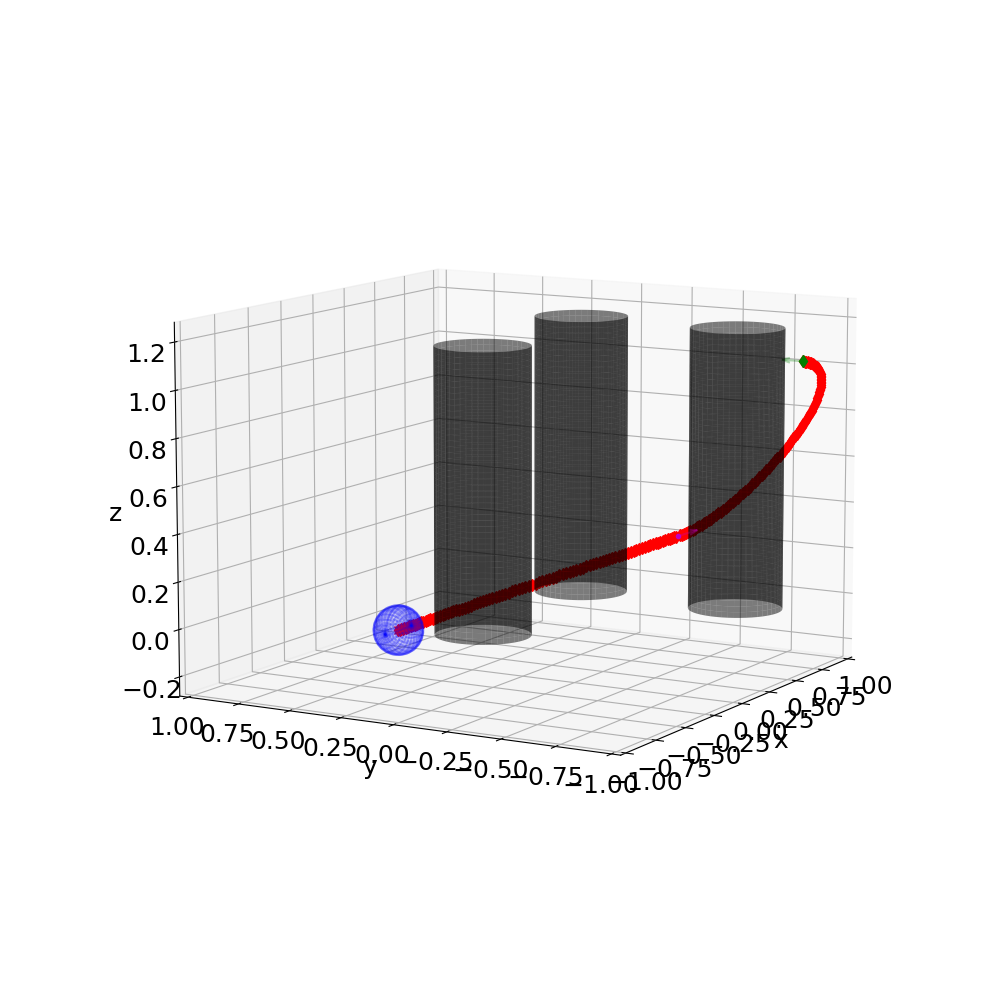

In [61]:
fx, fy, fz = planner_spline.get_curve_points(path_params=planner_spline.log_path[0], problem_params=problem_params, dt = 0.01)
curve = np.array([fx, fy, fz]).T
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,  projection='3d')
ax.plot(fx, fy, fz, '-')  
plt.plot(curve.T[0],curve.T[1],curve.T[2], 'dr')
ax.plot(fx[0], fy[0], fz[0], 'xr')  
ax.quiver(fx[0], fy[0], fz[0], problem_params["vinit"][0], problem_params["vinit"][1], problem_params["vinit"][2], arrow_length_ratio=0.4, alpha=0.3,  length=.1, normalize=True, color='red')

ax.plot(fx[-1], fy[-1], fz[-1], 'dg')  
ax.quiver(fx[-1], fy[-1], fz[-1], problem_params["vgoal"][0], problem_params["vgoal"][1], problem_params["vgoal"][2], arrow_length_ratio=0.4, alpha=0.3,  length=.1, normalize=True, color='green')

ax.plot(planner_spline.log_path[0][0],planner_spline.log_path[0][1],planner_spline.log_path[0][2], '.m')  

vx = np.cos(planner_spline.log_path[0][3]) * np.cos(planner_spline.log_path[0][4])
vz = np.sin(planner_spline.log_path[0][3]) * np.cos(planner_spline.log_path[0][4])
vy = np.sin(planner_spline.log_path[0][4])

ax.quiver(planner_spline.log_path[0][0],planner_spline.log_path[0][1],planner_spline.log_path[0][2], vx, vy, vz, arrow_length_ratio=0.4, alpha=0.3,  length=.1, normalize=True, color='m')


for obi in problem_params["obs"]:
    ax = plot_cylinder(center=(obi[0], obi[1]), radius= obi[3], ax=ax, color= 'black', alpha=0.5, height_z=1.2)     
    # ax = plot_ellipsoid(center=(obi[0], obi[1], obi[2]), dimensions=(obi[3], obi[4], obi[5]), ax=ax, color= 'black', alpha=0.5,Npoints=200)
    
ax = plot_ellipsoid(center=(fx[0], fy[0], fz[0]), dimensions=( problem_params["r"],  problem_params["r"],  problem_params["r"]), ax=ax, color= 'blue')    
# ax = plot_cylinder(center=(fx[0], fy[0]), radius= problem_params["r"], ax=ax, color= 'blue')    

ax.view_init(10,-150)
l = [-1, 1, -1, 1, -0, 1]
ax.set_xlim(l[0],l[1])
ax.set_ylim(l[2],l[3])
ax.set_zlim(l[4],l[5])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_aspect('equal')
plt.show()

In [62]:
# problem_params['pgoal']

In [63]:
x0 = problem_params['pinit'][0]+0.01
y0 = problem_params['pinit'][1]+0.01
z0 = problem_params['pinit'][2]+0.01
print(x0, y0, z0)
T_total = 10
agent = robot_3dholonomic_velocity(r=ragent, x0=x0, y0=y0, z0=z0, dt=0.05, color='blue', text_id='1')

while (np.linalg.norm(np.array([agent.x[-1], agent.y[-1], agent.z[-1]]) - np.array(problem_params['pgoal'])) > 0.01) and (agent.t < T_total):
    
    # print('t = ', agent.t)
    field = compute_field(curve, p=np.array([agent.x[-1], agent.y[-1], agent.z[-1]]), Kf=10, eta=1)
    # print(agent.x[-1], field)
    agent.step(vx=field[0], vy=field[1], vz= field[2])
print(agent.x[-1], agent.y[-1], agent.z[-1], problem_params['pgoal'])

-0.99 0.01 0.11
1.020604369405543 -0.6093671179197077 1.0084814483083706 [1.0, -0.8, 1.0]


In [64]:
# N = 15
# l = [-1,1,-1,1,0,1]
# x = np.linspace(-1,1,N)
# y = np.linspace(-1,1,N)
# z = np.linspace(-0,1,N)

# X = []
# Y = []
# Z = []
# VX = []
# VY = []
# VZ = []
# for xi in x:
#     for yi in y:
#         for zi in z:
#             F = compute_field(curve, p=np.array([xi, yi, zi]).T, Kf=10, eta=1)
#             # F = F/(np.linalg.norm(F)+1e-18)
#             X.append(xi)
#             Y.append(yi)
#             Z.append(zi)
#             VX.append(F[0])
#             VY.append(F[1])
#             VZ.append(F[2])
# plt.plot(agent.x, agent.y, agent.z, '--c')
# ax.quiver(X, Y, Z, VX, VY, VZ, arrow_length_ratio=0.4, alpha=0.3,  length=.1, normalize=True)
# plt.show()

In [65]:
def saveVideo(agents=[], curves=[], problem_params = None, T_total=1, N_dt=1, \
    dt=0.01, fig = None, frame_step = 1, variant_field=True,\
    path_result = 'trajectory.mp4', fps=10, path_keep = 1000,\
        xmin=-1, xmax = 1, ymin =-1, ymax = 1, zmin = 0, zmax = 1,\
            view_init=(15,-50), view_point=True, move_view=True, obstacles=[],\
                savefig=False, dpi=300, Nsavefig=10, \
                    check_collision=True, collison_gain=1.2, alpha_collison=0.5, collision_tol_r=1e-3, collison_color='black'):
    
    frames = []
    figs = []
    tk = 0
    total_collision = 0

    if fig is None:
        fig = plt.figure(figsize=(10,10))


    nagents = len(agents)
    for curve in curves:
        fx = [c[0] for c in curve]
        fy = [c[1] for c in curve]
        fz = [c[2] for c in curve]
        

    x_traj = [[] for i in range(nagents)]
    y_traj = [[] for i in range(nagents)]
    z_traj = [[] for i in range(nagents)]
    # for i in range(nagents):

    #     if not variant_field:
         
    #         x_trajA = [fn_trajectories[i](t)[0] for t in np.arange(0, T_total, N_dt*dt)]
    #         y_trajA = [fn_trajectories[i](t)[1] for t in np.arange(0, T_total, N_dt*dt)]
    #         z_trajA = [fn_trajectories[i](t)[2] for t in np.arange(0, T_total, N_dt*dt)]
    #         x_traj[i].append(x_trajA.copy())
    #         y_traj[i].append(y_trajA.copy())
    #         z_traj[i].append(z_trajA.copy())
    
   
    for k in range(len(agents[-1].x)):
        
        if k%frame_step == 0:
            print(f'\r{k/len(agents[0].x)*100:.2f}%', end="")
            #-----------------------------------------------------------------------
            fig.clear()    
            ax = fig.add_subplot(111,  projection='3d')
            ax.plot(fx, fy, fz, '--r')  
            ax.plot(fx[0], fy[0], fz[0], 'dr')  

            if problem_params is not None:
                ax.quiver(fx[0], fy[0], fz[0], problem_params["vinit"][0], problem_params["vinit"][1], problem_params["vinit"][2], arrow_length_ratio=0.4, alpha=0.3,  length=.1, normalize=True, color='red')

                ax.plot(fx[-1], fy[-1], fz[-1], 'dg')  
                ax.quiver(fx[-1], fy[-1], fz[-1], problem_params["vgoal"][0], problem_params["vgoal"][1], problem_params["vgoal"][2], arrow_length_ratio=0.4, alpha=0.3,  length=.1, normalize=True, color='green')
                
            for i in range(nagents):
                agents[i].plot_robot(ax=ax, k=k, kkeep=path_keep)
                ax.plot(fx[0], fy[0], fz[0], 'xr')  
                
                # agents[i].plot_robot(ax=ax, k=None)
                
                
                # if check_collision:                    
                #     for n in range(nagents):
                #         if n != i:
                #             dist_collision = (agents[i].x[k] - agents[n].x[k])**2 + (agents[i].y[k] - agents[n].y[k])**2 + (agents[i].z[k] - agents[n].z[k])**2 
                #             if dist_collision - (agents[i].r + agents[n].r)**2 + collision_tol_r < 0:
                #                 print(f'\nt = {np.round(tk,2):.2f} (kindex = {k})-> collsion beteween agent {agents[i].text_id} with agent {agents[n].text_id}, d = {dist_collision - (agents[i].r + agents[n].r)**2}')                            
                #                 print(f'x = {agents[i].x[k]:.2f}, y={agents[i].y[k]:.2f}, z={agents[i].z[k]:.2f}')
                #                 # print(f'x = {agents[n].x[k]:.2f}, y={agents[n].y[k]:.2f}, z={agents[n].z[k]:.2f}')
                #                 ax = plot_ellipsoid(center=(agents[i].x[k],agents[i].y[k],agents[i].z[k]), dimensions=(collison_gain*agents[i].r,collison_gain*agents[i].r,collison_gain*agents[i].r), ax=ax, Npoints=200, color=collison_color, alpha=alpha_collison)
                #                 total_collision += 1
                    
                
                
            # ax.plot3D(x_traj[i][0],y_traj[i][0],z_traj[i][0],'--', c=agents[i].color, alpha=0.4)
            
            for obi in obstacles:
                ax = plot_cylinder(center=(obi[0], obi[1]), radius= obi[3], ax=ax, color= 'black', alpha=0.5, height_z=1.2)     
            # for ob in obstacles:
            #     ax = plot_ellipsoid(center=(ob[0],ob[1],ob[2]), dimensions=(ob[3],ob[4],ob[5]), ax=ax, Npoints=200, color='black', alpha=0.1)

            ax.set_xlim(xmin,xmax)
            ax.set_ylim(ymin,ymax)
            ax.set_zlim(zmin,zmax)

            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
            # ax.view_init(10,-150)
            ax.set_aspect('equal')
            if move_view:
                ax.view_init(view_init[0]+k/len(agents[0].x)*10, view_init[1]+k/len(agents[0].x)*10)
            else:
                ax.view_init(view_init[0], view_init[1])


            title = f't = {np.round(tk,2):.2f}'
            ax.set_title(title)            
            
            # if savefig:
            #     if k%Nsavefig == 0:
            #         fig.savefig(f'./results/temp/{k}.jpg', bbox_inches = 'tight', pad_inches = 0, dpi=dpi)
            
            fig.canvas.draw()       # draw the canvas, cache the renderer
            
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,)) 
            frames.append(image)  
            # fig.canvas.close_event()
            # fig.canvas.
            # fig.canvas.mpl_connect('close_event', on_close)
            # plt.close()
            # fig.canvas.callbacks.process('close_event')
            
        tk += dt    
    
    writer = imageio.get_writer(path_result,fps=fps)
    for im in frames:
        writer.append_data(im)
    writer.close()
    
    print(f'\r100.00%', end="")
    if check_collision:
        print(f'\ntotal collisions = {total_collision/2:.0f}')
    return frames
    # optimize(path_result) # For overwriting the original one

/tmp/ipykernel_10861/1163795341.py:15: RuntimeWarning: More than 1 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,10))


98.51%

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


99.50%

[swscaler @ 0x6644d00] Warning: data is not aligned! This can lead to a speed loss


100.00%
total collisions = 0


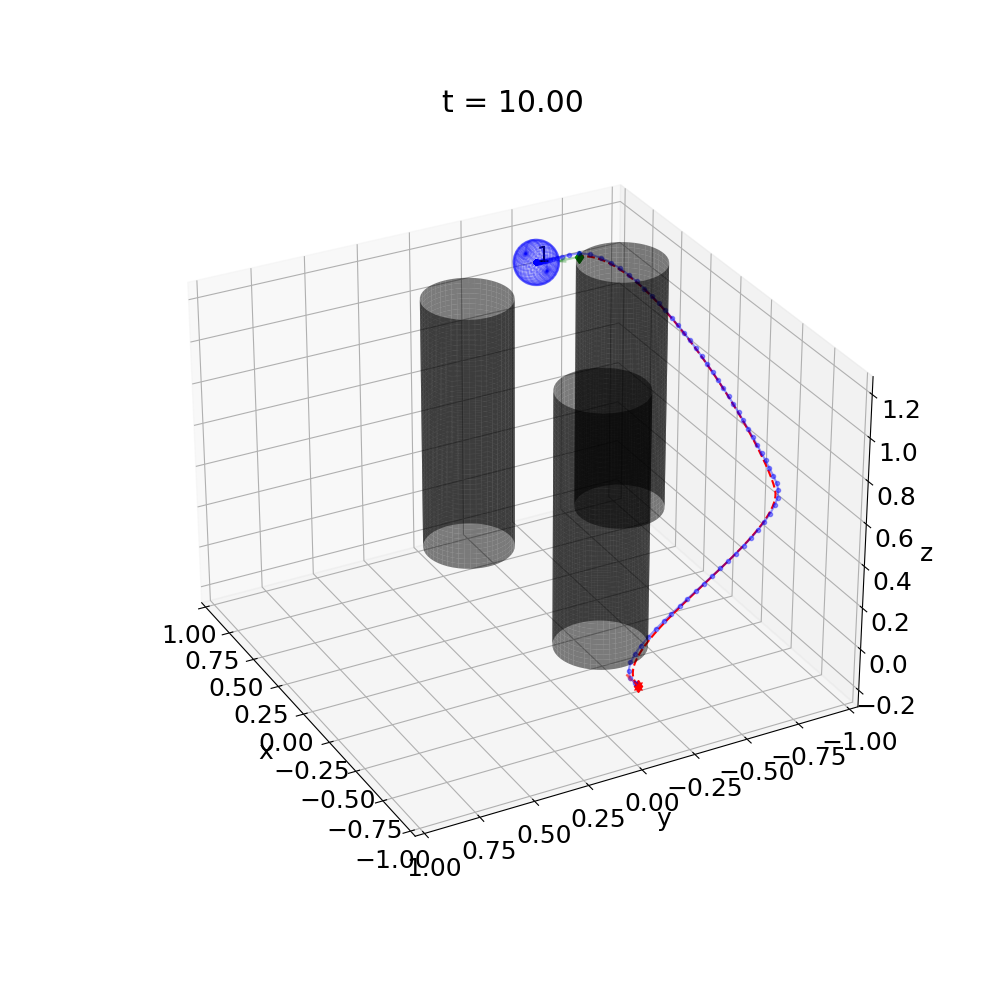

In [66]:
frames = saveVideo(agents=[agent], curves=[curve], problem_params = problem_params, obstacles=problem_params['obs'], \
    T_total=T_total, dt=0.05, \
        path_keep = 10000, move_view=False, \
        fps=10, frame_step=2,\
    view_init=(29,152), path_result = './trajectory2.mp4')

In [67]:
def on_close(event):
    pass
    # print('Closed Figure!')

In [68]:
np.sum(np.linalg.norm(np.diff(np.array([fx,fy, fz])).T, axis=1))

2.8743024611124834

In [69]:
test = [(1/(o[3]+0.1)**2)*(np.array(fx)-o[0])**2 + (1/(o[4]+0.1)**2)*(np.array(fy)-o[1])**2 + (1/(o[4]+0.1)**2)*(np.array(fy)-o[1])**2 - (1/(o[5]+0.1)**2)*((o[2]+0.1))**2 for o in problem_params["obs"]] 
test = np.array(test)
len(test[test < 1 ])

109

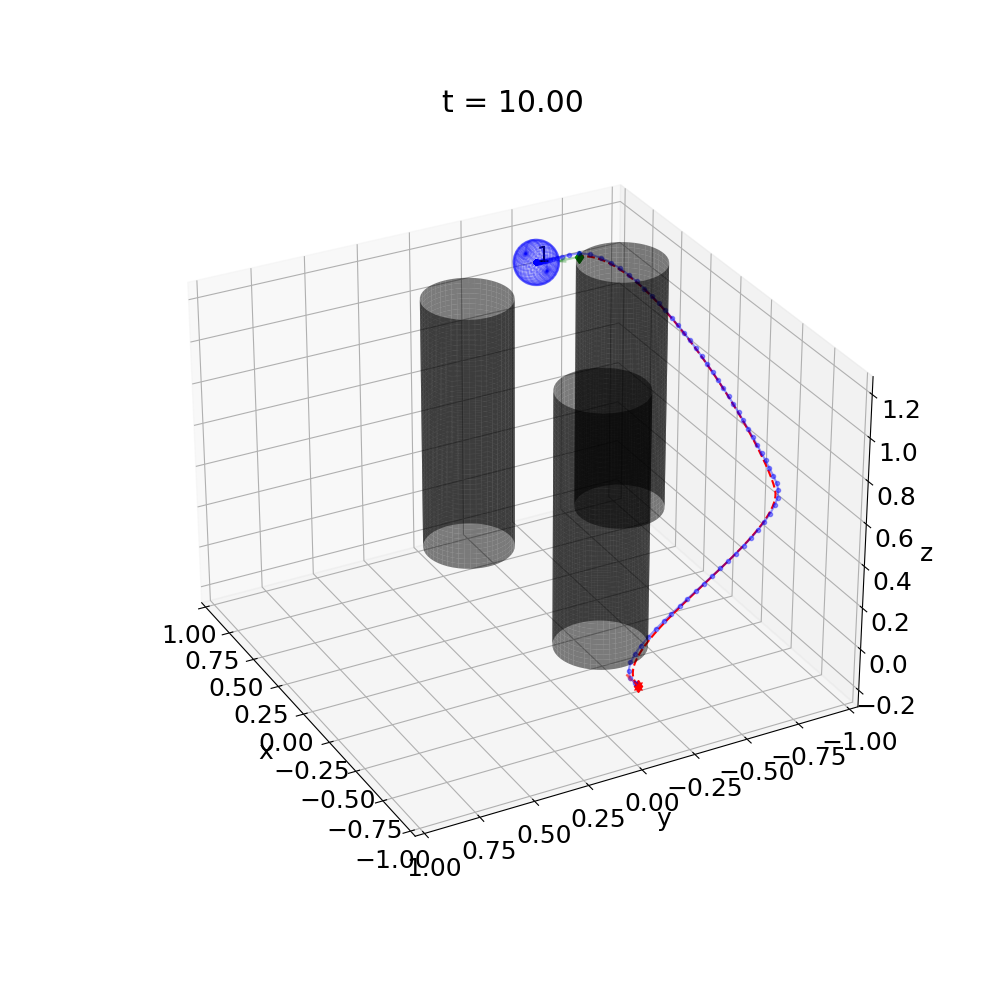

In [70]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


plt.show()